In [1]:
from IPython.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
from desdeo_emo.EAs import RVEA, NSGAIII
from desdeo_problem.testproblems.TestProblems import test_problem_builder
from desdeo_problem import DataProblem
from desdeo_tools.utilities import fast_non_dominated_sort, hypervolume_indicator

import matplotlib.pyplot as plt
import sklearn
from pyDOE import lhs
import pandas as pd


## Assignment 3

#### about acquisitio function in bayesian model management

## Task 1 

 Use EI and the mean prediction to solve any single objective benchmark problem (e.g.
Ackley, Rosenblock, sphere etc.) with any single objective optimizer (preferably GA). 

Set max exact function evaluations to 50 (start with 50 design points). Was the solutions
found by EI better? (you can implement EI is you wish to)

##### steps

voisi käyttää omaa GA, giomaran kurssilta. Siellä varmaan ratkaistu myös jokin single obj ongelma, täys pohja sieltä siihen. EI ja mean prediction ovat sitten se optimizer functio vaii?

max evals 50 ja 50 individuaalia..

mitä on mean prediction tässä tilanteessa? vai kuitenkin käytössä GRP ja GA on vaan optimizer? --  posterior predicted mean from Kriging surrogates <-- tässä varmaan mean prediction

Voisi eka ratkaista jollain helpolla ja sitten vähän vaikeemmalla kuten tuo hartmann jossa 6 lokaalia min ja 1 global ja 6 dims on x.

DOE meaning: 

In its simplest form, an experiment aims at predicting the outcome by introducing a change of the preconditions, which is represented by one or more independent variables, also referred to as "input variables" or "predictor variables." The change in one or more independent variables is generally hypothesized to result in a change in one or more dependent variables, also referred to as "output variables" or "response variables." 

Tämä slide:


Muistetaans nyt pääpointti. Meillä ei ole oikeita objektive funtioita käytössä tai liian kalliita. GRP sun muut on se kevyempi objektivefunctio. GA edelleen optimoija. data on populaation jäsenet decision space. laskettuna surrogatella GPR ne on surrogate objective space. Ja oikeilla sitten oikea objective space.

Oliko mean prediction error nyt sitten miten tämä mean prediction (surrogate) eroaa oikeasta mean ?

Easiest Approach (single objective)

- 1. Build surrogates with initial data (or DOE)
- 2. Optimize considering the mean prediction as objectives
- 3. Evaluate the solution with the expensive functions 
- 4. Rebuild the surrogates with the new data
- 5. Repeat Step 2 to Step 4 until maximum number of expensive function evaluation is reached

!!!! IMPORTATN !!!

we need to find the sampling points by optimizing the acf.

Acquicisiton functin (EI) shoudl be optimized?!

In [7]:
# Problem is the expensive function to evaluate.
# use ackley
def problem(x):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[0]**2 + x[1]**2)))
    term2 = np.exp(0.5 * (np.cos(2 * np.pi * x[0]) + np.cos(2 * np.pi * x[1])))
    return term1 - term2 + np.exp(1) + 20


In [8]:
problem([4,4])

11.013420717655569

In [ ]:
# IDEAA KUINKA HOMMA SKULAA

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

## TODO:

Now somewhat works.



-- also need to try EI but should first get atleast surrogates to wrok

-- run several times

-- either make bounded SBX or comment about it possibly doing issues with crossover


In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, RationalQuadratic, DotProduct, ConstantKernel, Matern

class real_GA:
    def __init__(self, problem, pop, pop_size, pm, bounds, di, order, acf=False, use_surr=False, max_func_evals=50, gen_max=50):
        self.problem = problem # problem function to solve
        self.pop = pop # pop array to hold binary population strings
        self.pm = pm # probability of mutation
        self.pop_size = pop_size # population size
        self.lbounds = bounds[0]
        self.ubounds = bounds[1]
        self.di = di # for crossover
        self.order = order # for mutation
        self.acf = acf
        self.use_surr = use_surr
        self.gen_max = gen_max # max generations
        self.max_func_evals = max_func_evals
        
        self.best_ind = None
        self.fitness = [] # fitness array to hold calculated fitness values
        self.gen = 0 # current generation
        self.surr = None
        
    
    # start pop and evaluate each member in the pop
    def initialize(self):
        if len(self.pop) < 1:
            x1range = np.random.uniform(low=self.lbounds[0], high=self.ubounds[0], size=self.pop_size)
            x2range = np.random.uniform(low=self.lbounds[1], high=self.ubounds[1], size=self.pop_size)
            self.pop = np.stack((x1range, x2range), axis=-1)
        
        self.fitness = np.array([self.evaluate(member) for member in self.pop]) # calculate fitness for each pop member
        

    # run the GA
    def run(self):
        n = 0 # init iterations
        self.initialize()
        
        # 1. building the surrogates with initial data
        if self.use_surr:
            # kernel = Matern(length_scale_bounds=(1e-10, 1000000))
            kernel = Matern(length_scale=1.0)
            self.surr = GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(self.pop, self.fitness)
            print("in first build", self.surr.score(self.pop, self.fitness))

        # 2. optimize part ?
        while self.gen_max > n:
            next_gen = [] # init next_gen population array
            for i in range(int(self.pop.shape[0]/2)):
                # select two individuals with deterministic tournament selection, append them in a next gen list for crossover
                i1, i2 = self.tour_select()
                s1 = self.pop[i1]
                s2 = self.pop[i2]
                next_gen.append(s1)
                next_gen.append(s2)
                
            # crossover. Happens every time
            next_gen = self.SBX(next_gen)
                
            # Mutation. happens if rand < pm for member in pop
            for i in range(self.pop_size):
                if np.random.rand() < self.pm:
                    next_gen[i] = self.poly_mutation(next_gen[i], self.order)
             
            self.pop = np.asarray(next_gen) # add next gen to self pop 
            
            # evaluate the population members, using surrogates if wanted
            # 2. ?
            if self.surr is not None:
                best_idx = self.surrogate_part()
                # eval the solution with expesive functions
                best_fit = self.evaluate(self.pop[best_idx])
                self.best_ind = best_fit
                self.max_func_evals += 1
                
                # compute the best surrogate eval member's exact function value. Put it instead of the surrogate fitness value
                self.fitness[best_idx] = best_fit
                # self.fitness[np.where(np.argmin(self.fitness))] = best_fit # are these the same? meant to be, but not sure..
                
                # rebuilt surrogates?
                self.update_surrogates()
            else:    
                self.fitness = np.array([self.evaluate(member) for member in self.pop])
            n += 1
            self.gen += 1
        
        
        # evaluate the best individual with real func. TODO: to use this or not?
        self.best_ind = self.evaluate(self.pop[np.argmin(self.fitness)])
        

    def update_surrogates(self):
        kernel = Matern(length_scale=1.0)
        self.surr = GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(self.pop, self.fitness)
        #print("updating surr", self.surr.score(self.pop, self.fitness))

    # 2. ?
    def surrogate_part(self):
        if self.acf:
            # use EI here too
            mean, std = self.surr.predict(self.pop, return_std=True)
            max_val = np.max(mean)
            tradeoff = 0.5
            mean_pred = EI(mean, std, max_val, tradeoff)
            best_idx = np.argmax(mean_pred) # MAXIMIZE EI
            return best_idx
    
        # otherwise just use mean posteriory pred
        mean_pred = self.surr.predict(self.pop)
        self.fitness = mean_pred
        best_idx = np.argmin(mean_pred)
        return best_idx
    
    
    # evaluate population members
    def evaluate(self, member):
        # constraint evaluation       
        fitness = self.fitness_evaluation(member)
        return fitness
        
    # evaluates constraint violations and updates the fitness value by chosen penalty constraint method
    def fitness_evaluation(self, x):
        # constraint evaluation  
        #x, infeasible = check_constraints(x)
        fitness = problem(x)          
        return fitness
        
        
    # deterministic binary tournament selection
    def tour_select(self):        
        cf = self.fitness
        b1 = np.argmin(cf) # get best member by fitness
        cf = np.delete(cf, b1) # remove it from cf
        b2 = np.argmin(cf) # get (2nd) best member by fitness
        return b1, b2 # return best and 2nd best members as parents
        
        
    # Simulated binary crossover (non-bounded)
    def SBX(self, parents):
        parents = np.asarray(parents)
        pop_size, num_var = parents.shape
        children = np.zeros_like(parents)
        for i in range(0, pop_size, num_var):
            p1 = (parents[i] + parents[i + 1]) / 2
            p2 = (parents[i] - parents[i + 1]) / 2
            beta = np.zeros(num_var)
            alpha = np.random.rand(num_var)
            bx = np.random.randint(0, high=2, size=num_var)
            beta[alpha <= 0.5] = (2 * alpha[alpha <= 0.5])**(1 / (self.di + 1))
            beta[alpha > 0.5] = (2 - 2 * alpha[alpha > 0.5])**(-1 / (self.di + 1))            
            beta = beta * ((-1)**bx)
            children[i] = p1 + beta * p2
            children[i + 1] = p1 - beta * p2
        return children
        
    
    # polynomial mutation for one pop member p
    def poly_mutation(self, p, order):
        children = np.array([0,0])
        for i in range(0, 2):
            pL = self.lbounds[i]
            pU = self.ubounds[i]
            u = np.random.random() # r [0,1]
            mp = 0
            dl = (2*u)**(1/1+order) - 1
            dr = 1 - (2*(1 - u))**(1/1+order) 
            if u <= 0.5:
                mp = p[i] + dl*(p[i] - pL)
            else:
                mp = p[i] + dr*(pU - p[i])
            children[i] = mp
        return children

In [10]:
# best fitness 1.3862981070613571
# best variable values [-0.05708943 -0.00045767]

# normal GA just gets stuck on some local min anytime.

# global optimum of ackley f(0,0) = 0.

In [11]:
# this works weird with desdeo ??
# should be just like
# lhs(30, 100) but :o

def create_samples(dec_dim, samples):
    # create samples 
    x = lhs(dec_dim, samples)
    return x

In [127]:
# https://modal-python.readthedocs.io/en/latest/_modules/modAL/acquisition.html#max_EI
from scipy.stats import norm
from scipy.special import ndtr

def EI(mean, std, max_val, tradeoff):
    z = (mean - max_val - tradeoff) / std
    return (mean - max_val - tradeoff) * ndtr(z) + std * norm.pdf(z)

In [128]:
# params
pop_s = 50
pm = 0.1
bounds = np.array([[-1, -1], [1, 1]]) # variable bounds (lower, upper)
gen_max = 50
use_surr = True
fmax = 50 # max func evals
di = 2 # distribution index
order = 20 # polynomial order param

times = 20

### Using mean pred

In [129]:
mean_pred_result_all = []

In [130]:
for _ in range(times):
    acf = False # use acquicisition function EI
    pop = create_samples(2, pop_s)

    ga = real_GA(problem, pop, pop_s, pm, bounds, di, order, acf, use_surr, fmax, gen_max) 
    ga.run()
    fittest_idx = np.argmin(ga.fitness)
    print("best surrogate fitness", ga.fitness[fittest_idx])
    print("best decision values", ga.pop[fittest_idx])
    print("best exact func value", ga.best_ind)
    mean_pred_result_all.append(ga.best_ind)

in first build 1.0
best surrogate fitness -0.023002369761355723
best decision values [ 9.80503082e-03 -1.36731449e-09]
best exact func value 0.030290800480049285
in first build 1.0
best surrogate fitness -7.166498422622681
best decision values [0.00591616 0.00250669]
best exact func value 0.019272481127455166
in first build 1.0
best surrogate fitness 0.0
best decision values [0. 0.]
best exact func value 0.0
in first build 1.0
best surrogate fitness -5.134289979934692
best decision values [0.         0.00014223]
best exact func value 0.000402816257548011
in first build 1.0
best surrogate fitness -10.407612681388855
best decision values [-1.80289596  0.        ]
best exact func value 5.278588195085181
in first build 1.0
best surrogate fitness -2.3373260498046875
best decision values [-2.80758533e+00  7.38234900e-07]
best exact func value 7.304365913784219
in first build 1.0
best surrogate fitness -0.2398583641976413
best decision values [ 6.19446400e-04 -5.24516219e+00]
best exact func 

In [131]:
mean_pred_result_all

[0.030290800480049285,
 0.019272481127455166,
 0.0,
 0.000402816257548011,
 5.278588195085181,
 7.304365913784219,
 11.518993812938891,
 2.4900329210351266,
 3.648191757577024e-07,
 2.410149652013857,
 0.6403680475184963,
 1.1334722574849572,
 0.07089178320847722,
 0.04431756883939286,
 0.019548380246579455,
 0.045732636837144014,
 0.0,
 4.524790766821834,
 0.0,
 5.661193410199395]

In [132]:
np.mean(mean_pred_result_all)

2.0596205904348888

### using EI

In [133]:
EI_result_all = []

In [134]:
for _ in range(times):
    acf = True
    pop = create_samples(2, pop_s)
    
    ga = real_GA(problem, pop, pop_s, pm, bounds, di, order, acf, use_surr, fmax, gen_max) 
    ga.run()
    fittest_idx = np.argmin(ga.fitness)
    print("best surrogate fitness", ga.fitness[fittest_idx])
    print("best decision values", ga.pop[fittest_idx])
    print("best exact func value", ga.best_ind)
    EI_result_all.append(ga.best_ind)

in first build 1.0
best surrogate fitness 2.623570269477682e-05
best decision values [-7.36766571e-06 -6.76024811e-04]
best exact func value 0.001924371285170423
in first build 1.0
best surrogate fitness 0.0
best decision values [-5.14879381e-04  7.89205943e-06]
best exact func value 0.0014635307182935264
in first build 1.0
best surrogate fitness 0.0002703982264300464
best decision values [0.00013746 0.00049794]
best exact func value 0.0014681685430772973
in first build 1.0
best surrogate fitness 4.97933999419331e-05
best decision values [-2.58363766e-03  2.24461353e-08]
best exact func value 0.007485370397358082
in first build 1.0
best surrogate fitness 0.00012205714234880816
best decision values [-4.40015183e-05  2.45091732e-06]
best exact func value 0.00012469971984430117
in first build 1.0
best surrogate fitness 0.7589543891016781
best decision values [-0.06776776 -0.37715715]
best exact func value 2.6713754586722303
in first build 1.0
best surrogate fitness 0.00022801198348076923


In [135]:
EI_result_all

[0.001924371285170423,
 0.0014635307182935264,
 0.0014681685430772973,
 0.007485370397358082,
 0.00012469971984430117,
 2.6713754586722303,
 1.4337507863221681,
 0.0,
 2.308632362675258,
 3.2386868841142693,
 4.5551605667282224,
 13.65799127666248,
 0.2769133887457187,
 0.007291839398654076,
 2.8870052018196866,
 0.10679737045125037,
 2.637531092108304,
 0.0,
 5.295597524934692e-07,
 2.637531092108304]

In [136]:
np.mean(EI_result_all)

1.8215566995015025

## TODO:

check code for mistakes.

make loops to run both algos atleast 10 times. Then can compare the results between runs.

-- for now EI one seems to work very nice. mean pred not so nice always, which might be as expected.


Was assuming EI will be better, but with several 20-run blocks there was no clear winner. Maybe due to GA implementation there is too much randomness? atleast SBX is not bounded maybe that.

#### Botorch stuff

## Task 2

Solve any benchmark problems (K=2 and 5, n=10) with ParEGO and LCB.
Start with 109 design points. Compare the hypervolume of the solutions after 100 exact function
evaluations.

#### Notes

$$
LCB(x) = \mu(x) - \beta \sigma (x)
$$

β is a parameter controlling the
degree of exploration


Maybe try Botorch? now reason to try the framework!

https://botorch.org/tutorials/multi_objective_bo

has example here how to use parEGo

https://github.com/shinya-ml/Multiobj-Bayes-opt

Basically, MOPGI, custom class wrapper for Gpy's GPR to handle multiple outputs. Has also predict method using NSGA-II as the optimizer. Query dataset.get_observed seems to be the part where calls the optim.

Then max iter loop for ParEGO, optim, fit using MOPGI, until done.

##### steps

- LHS? to generate 109 design points
- LCB and ParEGO are acquisition fucntions.. Use NSGA-III or whatever as the optimizer.


ParEGO

1. Draw random weight vector λ
2. Scalarize the objectives (using ASF) for the
provided data
3. Build GP on the scalarized objectives
4. Maximize EI
5. Evaluate and Repeat from step 1

-- use LCB first, simpler.

In [ ]:
# https://github.com/yunshengtian/DGEMO/blob/master/mobo/mobo.py

# idea how Multiobjective bayesian optimization goes

# if nothing else use this repo bc it should be able to do the things

In [20]:
def LCB(mean, std, beta=.5):
    return mean - beta*std

In [13]:
#https://github.com/automl/SMAC3/blob/main/smac/optimizer/multi_objective/parego.py

#rho = 0.05

# Then we have to compute the weight
theta = self.rng.rand(self.num_obj
# Normalize st all theta values sum up to 1
theta = theta / (np.sum(theta) + 1e-10
#Weight the values
theta_f = theta * valuereturn np.max(theta_f, axis=1) + self.rho * np.sum(theta_f, axis=1)

SyntaxError: invalid syntax (2459848700.py, line 8)

In [15]:
dtlz5_2 = test_problem_builder('DTLZ5', n_of_variables=10, n_of_objectives=2)

In [16]:
x = create_samples(10, 109)
x[:1]

array([[0.91951996, 0.79860568, 0.32740432, 0.16544181, 0.41547068,
        0.95738555, 0.49552473, 0.84539565, 0.92692711, 0.61035256]])

In [25]:
y = dtlz5_2.evaluate(x)
y.objectives[:5]
y = y.objectives
y1 = y[:,0]
y2 = y[:,1]

In [26]:
print(y.shape)
print(y1.shape)
print(y2.shape)

(109, 2)
(109,)
(109,)


In [19]:
x_names = [f'x{i}' for i in range(1,11)]
y_names = ["f1", "f2"]

data = pd.DataFrame(np.hstack((x,y)), columns=x_names+y_names)
#data

In [156]:
# problem = DataProblem(data=data, variable_names=x_names, objective_names=y_names)

In [27]:
## params

#x_bound = np.zeros(10)
#rho = 0.
#xi = 1.

kernel = Matern(length_scale=1.0)
gpr1 = GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y1)
gpr2 = GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y2)

In [30]:
for i in range(1):
    # predict with surrogates
    y1_pred, std1 = gpr1.predict(x, return_std=True) 
    y2_pred, std2 = gpr2.predict(x, return_std=True) 
    
    # calc LCB
    y1_lcb = LCB(y1_pred, std1)
    y2_lcb = LCB(y2_pred, std2)
    
    y1_idx = np.argmin(y1_lcb)
    y2_idx = np.argmin(y2_lcb)

    # add to data ?
    x = np.append(x, [y1_idx])
    

0.009014959543760418
0.028814023908107982


In [179]:
class ParEGO():
    """
    This class keep attributes and method about ParEGO
    Attributes
    ----------
    x_bounds : list
        input domain which is optimized.
    x_train : numpy.array
        observed input data
    y_train : numpy.array
        observed output data
    rho : float
        hyper parameter in chebyshev scalarization
    xi : float
        hyper parameter in Expected Improvement
    """
    def __init__(self, x_bounds, x_train, y_train, rho, xi):
        self.x_bounds = x_bounds
        self.x_train = x_train
        self.y_train = y_train
        self.rho = rho
        self.xi = xi
        self.task_num = y_train.shape[1]
        self.train_num = y_train.shape[0]
        self.f_theta = np.zeros(self.train_num)
    def calc_parego(self):
        """
        get the result of optimized ParEGO
        """
        self.scalarization()
        # res = minimize(self.EI, bounds=self.x_bounds, algomethod=1)
        res = self.EI()
        return res
    def scalarization(self):
        """
        scalarize observed output data
        """

        theta = np.random.random_sample((self.task_num))

        sum_theta = np.sum(theta)
        theta = theta / sum_theta
        
        theta_f = theta * self.y_train
        max_k = np.max(theta_f, axis = 1)
        rho_sum_theta_f = self.rho * np.sum(theta_f, axis = 1)
        self.f_theta = max_k + rho_sum_theta_f
    def obj(self, x):
        if np.any(np.all(self.x_train == x, axis=1)):
            return 1.0e5
        else:
            mean, var = self.model.predict(np.atleast_2d(x))
            std = np.sqrt(var[0,0])

            # mean_inv = (-1) * mean
            current_max = self.f_theta.max()
            # print(current_max)
            Z = (current_max - mean[0,0] - self.xi) / std
            # print(norm.cdf(Z))
            # print(norm.pdf(Z))
            ei = (-1) * (Z * std) * norm.cdf(Z) + std * norm.pdf(Z)
            # print(ei)
            return ei
    def EI(self):
        """
        construct a GP model for scalarized output data
        applying EI for this model
        """
        kernel = GPy.kern.RBF(self.x_train.shape[1])
        self.model = GPy.models.GPRegression(self.x_train, self.f_theta[:,None],kernel=kernel, normalizer=None)
        self.model['.*Gaussian_noise.variance'].constrain_fixed(1.0e-2)
        self.model['.*rbf.variance'].constrain_fixed(1.0)

        x_dist = distance.cdist(self.x_train, self.x_train)
        median = np.median(x_dist)
        if median == 0:
            lower = 1.0e-3
            upper = 100
        else:
            lower = 1.0e-3 * median
            upper = 100  * median
        self.model['.*rbf.lengthscale'].constrain_bounded(lower, upper)
        self.model.optimize_restarts()

        array_bounds = np.array(self.x_bounds)
        max_bound = np.argmax(array_bounds[:,0] - array_bounds[:,1])
        terminate_vol = (0.1 ** self.x_train.shape[1]) / (array_bounds[max_bound, 1] - array_bounds[max_bound, 0])
        res = minimize(self.obj, bounds = self.x_bounds, algmethod=1,volper = terminate_vol)
        return res

In [180]:
data[:5]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,f1,f2
0,0.560775,0.124008,0.308101,0.398957,0.725020,0.639573,0.283232,0.424593,0.467520,0.242308,0.877493,1.063341
1,0.423274,0.493814,0.365374,0.508758,0.106245,0.995189,0.289963,0.987092,0.046779,0.580918,1.504593,1.179525
2,0.168388,0.929267,0.337976,0.094917,0.636774,0.272181,0.410702,0.074885,0.081247,0.608744,1.757766,0.476090
3,0.008066,0.255611,0.774269,0.346813,0.877044,0.239686,0.338721,0.934012,0.470484,0.229505,1.656624,0.020991
4,0.094010,0.908879,0.864651,0.307506,0.202080,0.121143,0.065626,0.829762,0.758206,0.637416,1.931223,0.287277


In [182]:
from desdeo_problem.surrogatemodels import GaussianProcessRegressor


#problem.train(GaussianProcessRegressor, {"kernel": Matern(1.0)}) # train will do the fit with x, and y.

for i in range(10):
    
    #res = parego.cal_parego()
    
    print('-----result of DIRECT-----')
    print(res)
    
    initial_x = np.append(initial_x, [res.x], axis=0)
    # get next y
    next_y = 0
    initial_y = np.append(initial_y, [next_y], axis=0)
    
    data = pd.DataFrame(np.hstack((initial_x,initial_y.objectives)), columns=x_names+y_names)
    problem = DataProblem(data=data, variable_names=x_names, objective_names=y_names)
    problem.train(GaussianProcessRegressor, {"kernel": Matern(1.0)}) # train again with new data

AttributeError: 'list' object has no attribute 'shape'

In [162]:
## desdeo example

from desdeo_problem.surrogatemodels import GaussianProcessRegressor

problem.train(GaussianProcessRegressor, {"kernel": Matern(nu=3/2)})

evolver_G_opt = NSGAIII(problem, use_surrogates=True, selection_type="optimistic")
while evolver_G_opt.continue_evolution():
    evolver_G_opt.iterate()

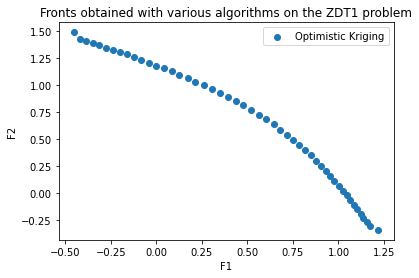

In [163]:
front_G_opt = evolver_G_opt.population.objectives - evolver_G_opt.population.uncertainity


G_opt = plt.scatter(x=front_G_opt[:,0], y=front_G_opt[:,1], label="Optimistic Kriging")

plt.title(f"Fronts obtained with various algorithms on the {problem_name} problem")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()